In [43]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.sql import SparkSession
from pyspark import SparkContext
import pandas as pd
import json
import glob
import os 

import matplotlib.pyplot as plt

In [44]:
spark = SparkSession.builder.config("spark.driver.memory", "30g")\
    .config("spark.driver.maxResultSize", '0').config("spark.executor.memory", "30g")\
    .config('spark.sql.autoBroadcastJoinThreshold', '-1').config('spark.local.dir','/ada/tmp').getOrCreate()


In [45]:
from pyspark.sql.functions import *
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, ArrayType, FloatType

schema = StructType([
    StructField('date', StringType(), True),
    StructField('numOccurrences', StringType(), True),
    StructField('phase', StringType(), True),
    StructField('probas', ArrayType(ArrayType(StringType()))),
    StructField("qids", ArrayType(StringType()), True),
    StructField('speaker', StringType(), True),
#     StructField('quotation', StringType(), True),
    StructField('quoteID', StringType(), True),
    StructField('urls', ArrayType(StringType()), True)
])

In [46]:
quote_files = glob.glob("*")
quote_files = [k for k in quote_files if 'json' in k]


In [26]:
quotes = spark.read.schema(schema).option("encoding", "UTF-8").json(quote_files)

# limit the dataset size for preliminary analysis and developing the pipeline
quotes.createOrReplaceTempView("data")


DataFrame[date: string, numOccurrences: string, phase: string, probas: array<array<string>>, qids: array<string>, speaker: string, quoteID: string, urls: array<string>]

In [90]:
from tld import get_tld

def get_domain(urls):
    tlds = [get_tld(k, as_object=True).fld for k in urls]
    return tlds

def extract_smallest_qid(qids):
    try: 
        if len(qids) > 1:
            vals = [int(k[1:]) for k in qids]
            vals.sort()
            response = vals[0]
        else:
            response = int(qids[0][1:])
        return response
    except:
        print('fail')
        return None

get_domain_udf = udf(get_domain, ArrayType(StringType()))
extract_smallest_qid_udf = udf(extract_smallest_qid, IntegerType())

In [91]:
# let's extract the top level domains
quotes = quotes.filter(quotes.speaker != "None")
quotes = quotes.withColumn('qid', extract_smallest_qid_udf("qids"))

quotes = quotes.withColumn("flds", get_domain_udf("urls"))


In [348]:
q = quotes.withColumn("date_only", to_date(col("date")))


In [349]:
q = q.withColumn("month", date_trunc("month", col("date_only")))

In [352]:
month_counts = q.groupby('month').count().toPandas()

In [357]:
month_counts.sort_values(by= 'month').to_csv("C:/Users/Venia/ada_projects/month_counts.csv",index=False)

In [92]:
quotes = quotes.select(quotes.qid, explode(quotes.flds).alias('fld'))
news_speaker_count = quotes.groupBy(['fld','qid']).count()

In [96]:
news_speaker_count.write.parquet("news_speaker_count.parquet")

In [97]:
news_speaker_count = spark.read.load('news_speaker_count.parquet')

In [235]:
# let's limit to pages with .com
# news_speaker_count= news_speaker_count.filter(news_speaker_count.fld.contains(".com"))

In [236]:

news_counts = news_speaker_count.groupby('fld').count()


speaker_counts = news_speaker_count.groupby('qid').count()

In [240]:
print('news: ')
news_counts.write.parquet("news_counts_usa.parquet")
print('speakers:')
speaker_counts.write.parquet("speaker_counts_usa.parquet")

news: 
speakers:


In [318]:
news_counts_df = news_counts.toPandas()

In [317]:
news_counts = spark.read.load('news_counts.parquet')
speaker_counts = spark.read.load("speaker_counts.parquet")

In [260]:
news_counts_df = news_counts.toPandas()
speaker_counts_df = speaker_counts.toPandas()

In [263]:
speaker_counts_df.to_csv("C:/Users/Venia/ada_projects/speaker_counts.csv", index=False)
news_counts_df.to_csv("C:/Users/Venia/ada_projects/news_counts.csv", index=False)

## Let's better understand the speaker and news site data
- we'll see how many times different speakers are quoted
- then we'll see how many news paper sites are there

In [103]:
# distrubition of speaker counts
speaker_counts_df = speaker_counts.toPandas()

In [112]:
speaker_counts_df.describe()

,qid,count
count,7.032880e+05,703288.000000
mean,1.786612e+07,50.235026
std,1.810502e+07,154.389625
min,7.600000e+01,1.000000
25%,4.707416e+06,2.000000
50%,7.822440e+06,6.000000
75%,2.704950e+07,29.000000
max,5.962784e+07,7463.000000


In [114]:
speaker_counts_df['count'].median()

6.0

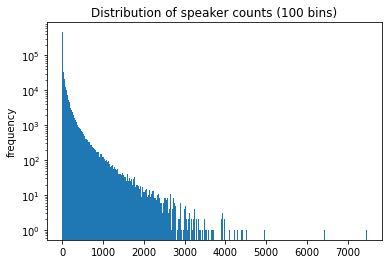

In [110]:
fig, ax = plt.subplots()
ax.hist(speaker_counts_df['count'], bins = 500, log = True)
ax.set_title("Distribution of speaker counts (100 bins)")
ax.set_ylabel('frequency')
plt.show()

In [106]:
news_counts_df = news_counts.toPandas()

In [111]:
news_counts_df.describe()

,count
count,12939.000000
mean,2730.480794
std,6148.156141
min,1.000000
25%,47.000000
50%,406.000000
75%,2073.500000
max,145157.000000


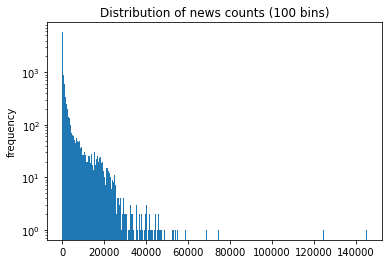

In [109]:
fig, ax = plt.subplots()
ax.hist(news_counts_df['count'], bins = 500, log = True)
ax.set_title("Distribution of news counts (100 bins)")
ax.set_ylabel('frequency')
plt.show()

How to decide on the threshold for speakers and news articles posted?

In [246]:
news_counts_filtered = news_counts.filter(news_counts['count'] > 10000)
speakers_filtered = speaker_counts[speaker_counts['count'] > 20]

In [250]:
speakers_filtered = speakers_filtered.withColumn('count_speaker', col('count')).select('qid','count_speaker')
news_counts_filtered = news_counts_filtered.withColumn('count_news', col('count')).select('fld','count_news')

In [251]:
## # analysis to get the term-frequencies and idf
data = news_speaker_count.join(speakers_filtered, on ='qid', how = 'inner')

# data= data.select('fld','qid','count')

data = data.join(news_counts_filtered, on ='fld', how = 'inner')
# data= data.select('fld','qid','count')


In [252]:
N = news_counts_filtered.count()

In [255]:
data2 = data.withColumn('tfidf', col('count') * log(N/col('count_speaker')).alias('tf-idf'))

In [256]:
data2.write.parquet("tfidf_possible_usa.parquet")

In [36]:
tfidf = spark.read.load('tfidf_possible.parquet')

In [ ]:
tfidf_df = tfidf.toPandas()

In [64]:
tfidf_df2.describe()

,qid,count,count_speaker,count_news,tfidf
count,3.260723e+07,3.260723e+07,3.260723e+07,3.260723e+07,3.260723e+07
mean,1.029060e+07,7.919392e+00,5.629782e+02,1.653862e+04,2.023598e+01
std,1.405103e+07,4.487051e+01,6.506846e+02,1.630550e+04,8.418194e+01
min,7.600000e+01,1.000000e+00,2.100000e+01,2.010000e+02,4.634337e-02
25%,8.884710e+05,1.000000e+00,1.350000e+02,6.098000e+03,4.201882e+00
50%,5.145011e+06,2.000000e+00,3.220000e+02,1.398300e+04,7.924473e+00
75%,1.590514e+07,5.000000e+00,7.400000e+02,2.149900e+04,1.644810e+01
max,5.962762e+07,4.999000e+03,7.463000e+03,1.451570e+05,2.900292e+04


In [50]:
# remove completely impossible numbers
tfidf_df2 = tfidf_df[tfidf_df['count'] < 5000]

In [51]:
pivoted = tfidf_df2.pivot(index='fld',columns ='qid', values='tfidf')


In [52]:
pivoted = pivoted.fillna(0)

In [53]:
# try standardizing?
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
pivoted_ = ss.fit_transform(pivoted.values)

In [276]:
# instead we'll normalize it 
# this is done as was recommended in lecture in class
from sklearn.preprocessing import normalize
nn = normalize(pivoted.values)

In [301]:
# to do the LSA we need to run PCA
from sklearn.decomposition import PCA 
pca = PCA(150)
vecs = pca.fit_transform(nn)

vecs_df = pd.DataFrame(vecs, index=pivoted.index)



In [303]:
vecs_df[list(range(150))] = vecs_df[range(150)].divide(np.linalg.norm(vecs_df[range(150)], axis = 1), axis = 0)


In [304]:

# we will use cosine similarity to find similarity
from sklearn.metrics import pairwise
cosine_similarity = pairwise.cosine_similarity(vecs_df.values)

cosine_similarity_df = pd.DataFrame(cosine_similarity, index=vecs_df.index,columns = vecs_df.index)

In [311]:
from sklearn.cluster import KMeans
km = KMeans(50)
km.fit(vecs)
clusters = km.predict(vecs)

In [312]:
vecs_df['cluster'] = clusters

In [313]:
bias_scores = pd.read_csv("bias_scores.csv")

In [314]:
domains = bias_scores.dropna(subset=['score'])

In [315]:
vecs_fb = vecs_df.merge(domains, left_index=True, right_on = 'domain', how = 'left')

In [316]:
vecs_fb.to_csv("C:/Users/Venia/ada_projects/quote_embedding.csv", index=False)

In [361]:
# for tensorflow embedding
vecs_fb[range(150)].to_csv("C:/Users/Venia/ada_projects/climate_vecs.tsv", sep = '\t', header=None,index=False)
vecs_fb[['domain','cluster','score','partisan_score']].to_csv('climate_metadata.tsv', sep = '\t', index=False)

In [81]:
# build embedding on climate quotes

In [82]:
climate_quotes = pd.read_csv("C:/Users/Venia/ada_projects/climate_quotes_full2.csv")

## Useless climate embedding generation

In [83]:
climate_quotes.drop('urls',inplace=True,axis=1)

In [84]:
climate_quotes['domains'] = climate_quotes['domains'].apply(lambda x: eval(x))

In [85]:
climate_quotes_exploded = climate_quotes.explode('domains')

In [268]:
climate_quotes[climate_quotes['quoteID'] == '2015-01-22-033642']

,date,numOccurrences,phase,probas,qids,speaker,quotation,quoteID,domains
114243,2015-01-22 05:00:00,366,E,"[['David Collings', '0.6466'], ['None', '0.333...","['Q3017697', 'Q58224653']",David Collings,"I think it would've been a shame to have 1,000...",2015-01-22-033642,"[bowdoinorient.com, bowdoinorient.com, bowdoin..."


In [265]:
climate_quotes_exploded[climate_quotes_exploded['quoteID'] == '2016-07-07-042460']

,date,numOccurrences,phase,probas,qids,speaker,quotation,quoteID,domains
0,2016-07-07 01:40:20,1,E,"[['President Barack Obama', '0.6954'], ['None'...",['Q76'],President Barack Obama,I urge this Congress to come up with a biparti...,2016-07-07-042460,dissidentvoice.org


In [150]:
climate_quotes_exploded = climate_quotes_exploded[climate_quotes_exploded['speaker'] != 'None']

In [159]:
domain_speaker_count = climate_quotes_exploded.groupby(['domains', 'speaker'])['qids'].count().reset_index()
domain_count = climate_quotes_exploded.groupby('domains')['qids'].count().reset_index()
speaker_count = climate_quotes_exploded.groupby('speaker')['qids'].count().reset_index()

domain_speaker_count.columns = ['domains','speaker','count']
speaker_count.columns = ['speaker','speaker_count']

domain_count.columns = ['domains','domains_count']

In [169]:
domain_count = domain_count[domain_count['domains_count'] > 20]
speaker_count = speaker_count[speaker_count['speaker_count'] > 10]

In [210]:
kk = domain_speaker_count.merge(domain_count)

In [211]:
kk = kk.merge(speaker_count)

In [212]:
N = len(domain_count)

In [213]:
kk['tf-idf'] = kk['count'] *kk['speaker_count'].apply(lambda x: np.log(N/x))

In [214]:
climate_pivoted = kk.pivot(index='domains',columns = 'speaker', values = 'tf-idf')

In [215]:
climate_pivoted = climate_pivoted.fillna(0)

In [233]:
from sklearn.decomposition import PCA 
pca = PCA(150)
climate_vecs = pca.fit_transform(climate_pivoted)

climate_vecs_df = pd.DataFrame(climate_vecs, index=climate_pivoted.index)

In [234]:
climate_sim = pairwise.cosine_similarity(climate_vecs_df.values)


In [235]:
cosine_similarity_df = pd.DataFrame(climate_sim, index=climate_vecs_df.index,columns = climate_vecs_df.index)

In [236]:
climate_vecs_df.reset_index(inplace=True)

In [238]:
climate_vecs_df = climate_vecs_df.merge(domains, left_on = 'domains', right_on = 'domain', how = 'left')

In [249]:
from sklearn.cluster import KMeans
km = KMeans(50)
km.fit(climate_vecs)
clusters = km.predict(climate_vecs)
climate_vecs_df['cluster'] = clusters

In [250]:
climate_vecs_df[range(150)].to_csv("C:/Users/Venia/ada_projects/vecs_climate.tsv", sep = '\t', header=None)
climate_vecs_df[['domains','score','fb_score','cluster']].to_csv("C:/Users/Venia/ada_projects/metadata_climate.tsv", sep = '\t')